In [1]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from wordcloud import WordCloud
from IPython import display
from matplotlib import pyplot as plt
import time

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = SparkSession.builder\
    .master('local[*]')\
    .appName('WordCloud')\
    .getOrCreate()

23/01/30 16:33:30 WARN Utils: Your hostname, matheus-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/01/30 16:33:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/30 16:33:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/30 16:33:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Tratamento dos tweets

- palavras em minúsculo;
- o "_c0' é o nome da coluna do DF;
- substituir no DF o que encontrar com http por "nada" '';
- remover os nomes dos usuários do twitter;
- remover a marcação dos rt dos retweets;
- transformar vazios em None;
- retirar os valores nulos

In [8]:
#deixar apenas as palavras

def trata_tweets(df):
    words = df\
        .select(f.explode(f.split(f.lower('_c0'), " ")).alias('word'))\
        .withColumn('word',f.regexp_replace('word', r'https:\S+', ''))\
        .withColumn('word',f.regexp_replace('word', r'@\w+', ''))\
        .withColumn('word',f.regexp_replace('word', 'rt', ''))\
        .na.replace('', None)\
        .na.drop()
    return words
        

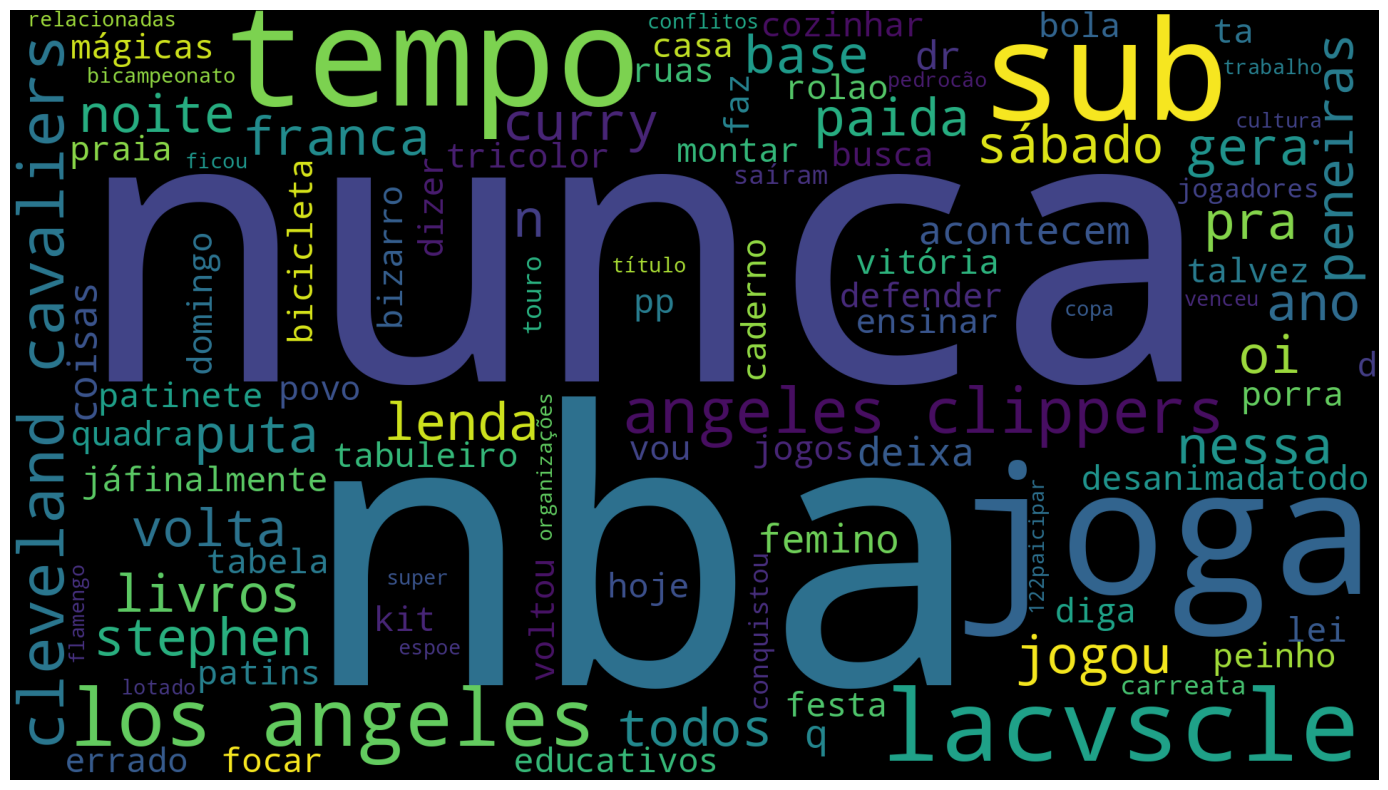

In [9]:
stops = stopwords.words('portuguese')
stops.append('basquete') #desconsiderar a palavra basquete pois, pois a analise é sobre e mesma e queremos o que orbita-a
plt.figure(figsize=(20,10))

#tratamento de erros
while True:
    try:
        words = spark.read.csv('./csv', encoding= 'utf-8')
        words = trata_tweets(words)
        rows = words.collect() #transformar o DF em lista de linhas para gerar o gráfico
        all_words = ''
        for row in rows:
            all_words = all_words + ' ' + row['word']
        
        wordcloud = WordCloud(stopwords = stops,
                              background_color = 'black',
                              width = 1920,
                              height = 1080,
                              max_words = 100).generate(all_words)

        plt.cla()                           #limpa os eixos do gráfico
        plt.axis('off')                     #ocultar marcações dos eixos
        plt.imshow(wordcloud)               #exibir dados como imagem
        display.display(plt.gcf())          #mostrar a wordcloud no output do notebook
        display.clear_output(wait = True)   #limpar o output do notebook
        time.sleep(5)                       #limpar a cada 5 segundos
    except KeyboardInterrupt:               #encerrar o processo comum comando do teclado
        break